In [1]:
%matplotlib inline

import collections
import os

from matplotlib import pyplot as plt
import numpy as np
import pymbar
from scipy.special import logsumexp
import seaborn as sns

from utils.mbarweights import compute_hrex_log_weight_trajectory, compute_scaled_mbar_weight_trajectories

In [2]:
%%html
<style>
body {
  counter-reset: section subsection;
}

h2 {
  counter-reset: subsection;
}

h2:before {
    counter-increment: section;
    content: "Section " counter(section) ". ";
}

h3:before {
    counter-increment: subsection;
    content: counter(section) "." counter(subsection) " ";
}
</style>

In [3]:
# Constants.
MBAR_WEIGHTS_DIR_PATH = os.path.join('..', 'mbar_weights')
BIAS_PREDICTION_CACHE = os.path.join(MBAR_WEIGHTS_DIR_PATH, 'bias_prediction_cache')
TRAILBLAZE_DIR_PATH = os.path.join(MBAR_WEIGHTS_DIR_PATH, 'trailblaze_potentials')
DOUBLY_SELF_CONSISTENT_CACHE = os.path.join(MBAR_WEIGHTS_DIR_PATH, 'doubly_self_consistent_cache')

## How the MBAR weights determine the bias

First, we check that we can reproduce the bias that we observed in SAMPLing from the MBAR weights.

In [4]:
# Load the MBAR energies.
mbar_energies = np.load(os.path.join(MBAR_WEIGHTS_DIR_PATH, 'SAMPLing-CB8-G3-0-complex-mbar-energies.npz'))['arr_0']

In [5]:
def compute_MBAR_free_energy_trajectory(mbar_energies, analyzed_iterations, verbose=True):
    """Run MBAR on each of the given iterations and return the free energy trajectory with uncertainties."""
    # Initialize the free energy array.
    n_analyzed_iterations = len(analyzed_iterations)
    n_states = mbar_energies.shape[0]
    Deltaf_in = np.empty(shape=(n_states, n_analyzed_iterations))
    dDeltaf_in = np.empty(shape=(n_states, n_analyzed_iterations))

    # Compute the MBAR free energies for all analyzed iterations.
    for i, analyzed_iteration in enumerate(analyzed_iterations):
        if verbose:
            print(f'\rIteration {analyzed_iteration} ({i+1}/{n_analyzed_iterations})', end='')
        N_k = np.array([analyzed_iteration for _ in range(mbar_energies.shape[0])])
        mbar = pymbar.MBAR(mbar_energies[:,:,:analyzed_iteration], N_k=N_k)
        result = mbar.getFreeEnergyDifferences()
        Deltaf_in[:,i], dDeltaf_in[:,i] = result[0][0], result[1][0]
    
    return Deltaf_in, dDeltaf_in

In [6]:
# Maximum number of analyzed iterations.
max_n_iterations = 5000
# Step between analyzed iterations.
step_iteration = 200

analyzed_iterations = list(range(step_iteration, max_n_iterations+1, step_iteration))

# Try to load the pre-computed data first.
Deltaf_file_path = os.path.join(BIAS_PREDICTION_CACHE, f'Deltaf_in-{step_iteration}-{max_n_iterations}.npy')
dDeltaf_file_path = os.path.join(BIAS_PREDICTION_CACHE, f'dDeltaf_in-{step_iteration}-{max_n_iterations}.npy')
try:
    Deltaf_in = np.load(Deltaf_file_path)
    dDeltaf_in = np.load(dDeltaf_file_path)
except FileNotFoundError:
    #If there is no cached data, compute the MBAR estimates at all iterations.
    Deltaf_in, dDeltaf_in = compute_MBAR_free_energy_trajectory(mbar_energies, analyzed_iterations)
    
    # Cache the result.
    np.save(Deltaf_file_path, Deltaf_in)
    np.save(dDeltaf_file_path, dDeltaf_in)

Now recompute the log weights using the best MBAR free energy estimates available at those iterations to verify that it indeed matches the bias obtained in SAMPLing.

In [7]:
# Try to load the pre-computed data first.
Deltaf_traj_weights_file_path = os.path.join(BIAS_PREDICTION_CACHE, f'Deltaf_traj_weights-{step_iteration}-{max_n_iterations}.npy')
log_weights_traj_base_path = os.path.join(BIAS_PREDICTION_CACHE, f'log_weights-{step_iteration}-{max_n_iterations}')
try:
    Deltaf_traj_weights = np.load(Deltaf_traj_weights_file_path)
except FileNotFoundError:
    # Compute the free energy trajectory from the MBAR weights.
    Deltaf_traj_weights = np.empty(shape=len(analyzed_iterations))
    for i, analyzed_iteration in enumerate(analyzed_iterations):
        print(f'\rIteration {analyzed_iteration} ({i+1}/{n_analyzed_iterations})', end='')
        
        # Compute and cache the log weights.
        mbar_log_weight_trajectories = compute_hrex_log_weight_trajectory(
            mbar_energies[:,:,:analyzed_iteration], Deltaf_in[:,i],
            computed_states=[0, Deltaf_in.shape[0]-1], verbose=False)
        np.save(log_weights_traj_base_path + f'-{i}.npy', mbar_log_weight_trajectories)
        
        Deltaf_traj_weights[i] = -logsumexp(mbar_log_weight_trajectories[0] - np.log(analyzed_iteration))
        Deltaf_traj_weights[i] += logsumexp(mbar_log_weight_trajectories[1] - np.log(analyzed_iteration))
    
    # Save the result.
    np.save(Deltaf_traj_weights_file_path, fDeltaf_traj_weights)

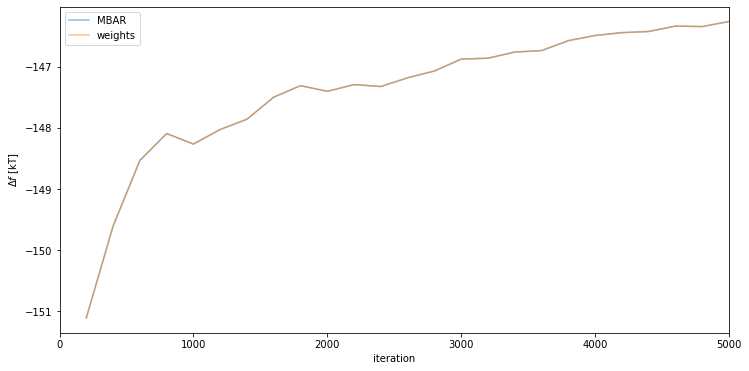

In [8]:
# Plot the free energy trajectories.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot(analyzed_iterations, -Deltaf_in[-1,:], label='MBAR', alpha=0.5)
ax.plot(analyzed_iterations, Deltaf_traj_weights, label='weights', alpha=0.5)
ax.set_ylabel('$\Delta f$ [kT]')
ax.set_xlabel('iteration')
ax.set_xlim((0, analyzed_iterations[-1]))
ax.legend()
plt.show()

We can reproduce the bias from the log weights.

### MBAR pushes all the bias on $\langle w_{decoupled} \rangle$

Now let's check how much the bias is due to $w_{bound}$ and how much it is due to $w_{decoupled}$ according to

$$\Delta F = f_{bound} - f_{decoupled} = -\mathrm{log}\langle w_{bound} \rangle + \mathrm{log}\langle w_{decoupled} \rangle$$

In [9]:
# Load the log weights and compute the separate f trajectories.
f_traj_weights_bound = np.empty(shape=len(Deltaf_traj_weights))
f_traj_weights_decoupled = np.empty(shape=len(Deltaf_traj_weights))
for i, analyzed_iteration in enumerate(analyzed_iterations):
    mbar_log_weight_trajectories = np.load(log_weights_traj_base_path + f'-{i}.npy')
    f_traj_weights_bound[i] = logsumexp(mbar_log_weight_trajectories[0] - np.log(analyzed_iteration))
    f_traj_weights_decoupled[i] = logsumexp(mbar_log_weight_trajectories[1] - np.log(analyzed_iteration))

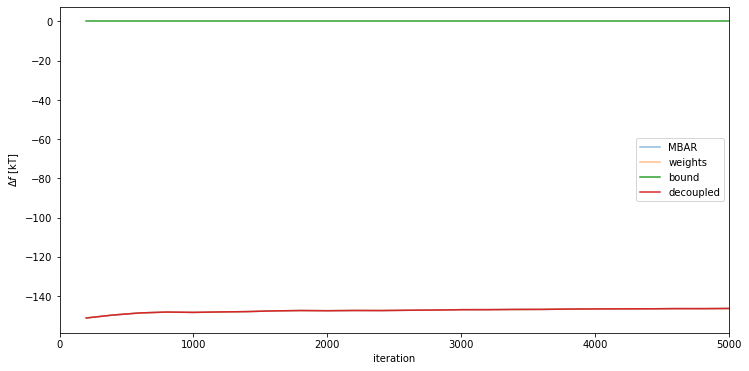

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot(analyzed_iterations, -Deltaf_in[-1,:], label='MBAR', alpha=0.5)
ax.plot(analyzed_iterations, Deltaf_traj_weights, label='weights', alpha=0.5)
ax.plot(analyzed_iterations, -f_traj_weights_bound, label='bound')
ax.plot(analyzed_iterations, f_traj_weights_decoupled, label='decoupled')
ax.set_ylabel('$\Delta f$ [kT]')
ax.set_xlabel('iteration')
ax.set_xlim((0, analyzed_iterations[-1]))
ax.legend()
plt.show()

MBAR pushes all the bias on the average MBAR weight of the decoupled state when it arbitrarily sets $f_{bound} = 0$. This means that we can try to estimate the bias by looking at the decoupled MBAR weights only.

### The bias is largely due to the biased MBAR free energies entering the expression of $w$.

Now let's see what happens if I just use the asymptotic free energy to estimate the MBAR weights instead of recomputing the MBAR.

In [11]:
# Load the SAMPLing free energies. This file is generated in the mbar_weight notebook.
converged_Deltaf_file_path = os.path.join(DOUBLY_SELF_CONSISTENT_CACHE, 'Deltaf-3.npz')
converged_Deltaf_ij = np.load(converged_Deltaf_file_path)['arr_0']
converged_dDeltaf_ij = np.load(converged_Deltaf_file_path)['arr_1']

# Load the asymptotic MBAR weights. This file is generated in the mbar_weight notebook.
converged_log_weights_file_path = os.path.join(DOUBLY_SELF_CONSISTENT_CACHE, 'log_weights-0.npz')
converged_log_weights = np.load(converged_log_weights_file_path)['arr_0']

In [12]:
# Compute cumulative free energy trajectory.
max_n_iterations = converged_log_weights.shape[-1]
Deltaf_traj = np.empty(max_n_iterations)
for i in range(0, max_n_iterations):
    Deltaf_traj[i] = -logsumexp(converged_log_weights[0][:i+1]- np.log(i+1))
    Deltaf_traj[i] += logsumexp(converged_log_weights[1][:i+1]- np.log(i+1))

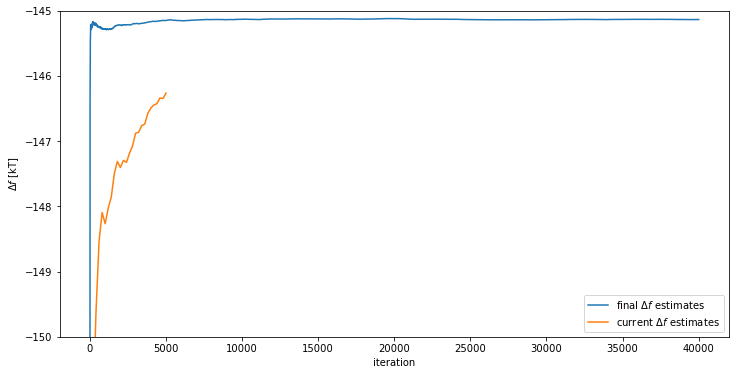

In [13]:
# Plot the free energy trajectory.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot(Deltaf_traj, label='final $\Delta f$ estimates')
ax.plot(analyzed_iterations, Deltaf_traj_weights, label='current $\Delta f$ estimates')
ax.set_ylabel('$\Delta f$ [kT]')
ax.set_xlabel('iteration')
ax.set_ylim((-150, -145))
ax.legend()
plt.show()

**The bias is greatly reduced when we use the correct free energy estimates to compute the weights**. This means that we'll have to compute the MBAR estimates at each iteration to hope to be able to estimate the bias decay.

Let's see what happens when we compute the MBAR weight free energy trajectory computed using the sequence of MBAR free energy predictions.

In [14]:
def compute_cumulative_Deltaf_weights_traj(
    mbar_energies, Deltaf_in, analyzed_iterations,
    compute_all_weights=False,
    log_weights_cache_base_path=None, verbose=False
):
    """Compute the MBAR log weights using the MBAR free energies at each iteration."""
    n_iterations = np.max(analyzed_iterations)

    Df_trajectories = []
    #Df_parameters = []

    for i, analyzed_iteration in enumerate(analyzed_iterations):
        if verbose:
            print(f'\rIteration {analyzed_iteration} ({i+1}/{len(analyzed_iterations)})', end='')
        
        # Check how many weights we need to compute.
        if compute_all_weights:
            traj_len = n_iterations
        else:
            traj_len = analyzed_iteration
        
        # Check if the log weights are cached somewhere or compute them.
        try:
            mbar_log_weight_trajectories = np.load(log_weights_cache_base_path + f'-{i}.npy')
        except (TypeError, FileNotFoundError):
            # Compute log MBAR weights using the best Df estimates at this iteration.
            mbar_log_weight_trajectories = compute_hrex_log_weight_trajectory(
                mbar_energies[:,:,:traj_len], Deltaf_in[:,analyzed_iteration],
                computed_states=[0, Deltaf_in.shape[0]-1],
                verbose=False
            )
    
        # Compute the free energy trajectory from these weights.
        Df_trajectories.append(np.empty(shape=(traj_len)))
        for i in range(traj_len):
            Df_trajectories[-1][i] = -logsumexp(mbar_log_weight_trajectories[0][:i+1] - np.log(i+1))
            Df_trajectories[-1][i] += logsumexp(mbar_log_weight_trajectories[1][:i+1] - np.log(i+1))
        
        # # Fit a 1-exponential decay model on the free energy.
        # popt, pcov = fit_f_t(
        #         n_exponentials=1,
        #         iterations=iterations,
        #         Deltaf=Df_trajectories[-1],
        #     )
        # Df_parameters.append(popt)
    
    if verbose:
        print()
    return Df_trajectories#, Df_parameters

In [15]:
cumulative_Df_traj_weight = compute_cumulative_Deltaf_weights_traj(
    mbar_energies=mbar_energies,
    Deltaf_in=Deltaf_in,
    analyzed_iterations=analyzed_iterations,
    log_weights_cache_base_path=log_weights_traj_base_path,
    verbose=True
)

Iteration 5000 (25/25)


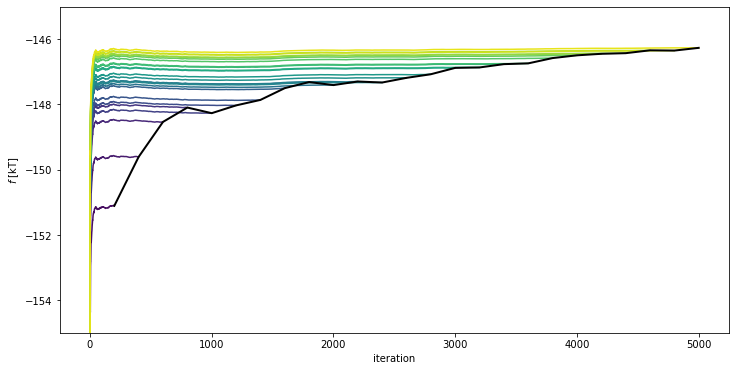

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
iterations = np.array(list(range(analyzed_iterations[-1])))
viridis = sns.color_palette('viridis', n_colors=len(cumulative_Df_traj_weight))

for i, Df in enumerate(cumulative_Df_traj_weight):
    # Plot data trajectory.
    ax.plot(iterations[:analyzed_iterations[i]], Df, label=str(analyzed_iterations[i]), color=viridis[i])

# Now print the real free energy trajectory.
ax.plot(analyzed_iterations, -Deltaf_in[-1], label='real', color='black', lw=2)

# Configure Axes.
ax.set_ylabel('$f$ [kT]')
ax.set_xlabel('iteration')
ax.set_ylim((-155, -145))
#ax.legend()
plt.show()

The decay can be modeled as a two separate decays. One related to the biased MBAR free energies, and one related to the sampling bias of the MBAR weight, which is much faster to decay. The biased MBAR free energy seem to affect the weight free energies by a factor that is roughly constant.

## A Markov state model of replica exchange

We can model the replica exchange process using a master equation where the state $(k, x) \in \mathbb{N}^{K!} \times \mathbb{R}^{3D}$ represents the tuple of states associated to each replica and the coordinates of the atoms. If we **assume that the coordinates can be discretized into Markov states with transition matrix** $T_{ij}$, we can model the distribution of the states starting from $p_i(0)$ through a propagator

$$P(t) = \mathrm{exp}(Tt)P(0) = \sum_m \phi^R_m \otimes \left[ \phi^L_m \cdot P(0) \right] e^{\lambda_m t}$$

where $P(t) = \mathrm{diag}(p_0(t), p_1(t), ...)$, $\phi^{L/R}_m$ and $\lambda_m$ are the m-th left/right eigenvector and eigenvalue of the transition matrix.


### A model of the bias

MBAR pushes the bias on one of the two end states so the bias of $\Delta f$ is equal to the bias of

$$f(t) = - \mathrm{log} \left( \frac{1}{t} \sum_i^t w(i) \right) = - \mathrm{log} \left(1 + \frac{1}{t} \sum_i^t \frac{w(i) - \langle w \rangle}{\langle w \rangle} \right) - \mathrm{log}\langle w \rangle$$

where $w(i)$ is the HREX MBAR weight sampled at iteration $i$, and $\langle w \rangle$ is the average weight at equilibrium. If the time average is small we can expand the first logarithm around the time average and the bias becomes

$$b_f(t) = \langle f(t) \rangle + f(\infty) = - \frac{1}{\langle w \rangle_{p(\infty)} t} \sum_i^t \langle w(i) \rangle_{p(i)} - \langle w \rangle_{p(\infty)} = - \frac{1}{\langle w \rangle_{p(\infty)} t} \sum_i^t b_w(i)$$

where $p(i)$ is the distribution at iteration $i$, which can be different from the equilibrium distribution of the Markov process $p(\infty)$ during equilibration, and $b_w(i)$ is the bias of the weight.

To understand the decay of the bias, we adopt the typical notation of Markov state formalism and use $w(t)$ to indicate a vector of the same dimension of $p(t)$. The MBAR weight vector generally depends on time because the expected maximum likelihood estimates of the free energies for each thermodynamic state will vary over time (and will be possibly biased as well).

$$b_w(t) = \langle w - \langle w \rangle_{p(\infty)} \rangle_{p(t)} = p(t) \cdot \left[ w(t) - \mathbb{1} ~ (p(\infty) \cdot w(t)) \right] = p(t) \cdot \left[ I - \mathbb{1} \otimes p(\infty) \right] \cdot w(t) = p(t) \cdot \left( I - \overline{P} \right) \cdot w(t) $$

where $\mathbb{1}$ is the all-one vector and $\overline{P} = \lim_{t \to \infty} \mathrm{exp}(Tt)$ is the matrix having each row equal to $p(\infty)$. Thus

$$b_w(t) = \mathbb{1} \cdot P(t) \cdot \left( I - \overline{P} \right) \cdot w(t) = \sum_m \mathbb{1} \cdot \phi^R_m \otimes \phi^L_m \cdot P(0) \cdot \left( I - \overline{P} \right) \cdot w(t) ~ e^{\lambda_m t}$$

### With a large number of states, the decay time of the bias increases proportionally to the number of states

We can observe the dependency of the bias on the number of states $K$ by relating the simulated time $t$, which is proportional to the number of HREX iterations $N$, to the computing time $t \propto N = \frac{t_{comput}}{t_{kn}K}$, where $t_{kn}$ is the computing time required to propagate one replica for one iteration (ignoring the time required to perform the swaps and compute the MBAR energy matrix). The bias decays as

$$b(t) = \sum_m \alpha_m(t, K) ~ e^{\lambda_m(K) ~ \gamma \frac{t_{comput}}{t_{kn} K}}$$

where $\alpha_m$ now includes all the information about the eigenvectors of the transition matrix, the initial distribution, and $w(t)$. Moreover, both $\lambda_m$ and $\alpha_m$ depend on the number of states because using different intermediate states change the transition matrix. Under the **main assumption that $\alpha_m$ and $\lambda_m$ approach a constant value in the limit of large $K$, the bias decay times $\tau_m = \frac{t_{kn} K}{\gamma \lambda_m}$ increases proportionally to the number of states**.

The condition is always satisfied when we know exactly the MBAR free energies (i.e., we have an unbiased vector $w(\infty)$) and there are no swaps between replicas. In this case, the transition matrix is block diagonal and the bias becomes

$$b(t) = \sum_k^K \sum_{m_k} \alpha_{m_k} e^{\lambda_{m_k} \gamma \frac{t_{comput}}{t_{kn} K}} \ge K \sum_{m_{k^*}} \alpha_{m_{k^*}} e^{\lambda_{m_{k^*}} \gamma \frac{t_{comput}}{t_{kn} K}}$$

where $k^*$ is the thermodynamic state along the alchemical variable for which the bias decays faster.


### With a large number of states, the variance increases with the number of states

**TODO**

## Can we predict the bias decay time by fitting a model?

### A dominant eigenvectors model

Let's try to fit the time series of the MBAR weights to an exponential decay model. The free energy of the decoupled state as a function of the iteration $t$ is modeled as

$$f(t) = -\mathrm{log}\langle w \rangle - \frac{1}{t \langle w \rangle}\sum_{i=0}^t \sum_m \alpha_m e^{-i/\tau_m} $$

substituting the sum with an integral we can use the cumulative density function of the exponential distribution to find

$$f(t) = -\mathrm{log}\langle w \rangle - \frac{1}{t} \sum_m \frac{\alpha_m \tau_m}{\langle w \rangle} \left( 1 - e^{-t/\tau_m} \right) = -\mathrm{log}\langle w \rangle - \frac{1}{t} \sum_m \gamma_m \left( 1 - e^{-t/\tau_m} \right)$$

where $\gamma_m$ is a parameter used to fitting to avoid numerical over/underflowing problems when taking the exponent of $\mathrm{log}\langle w \rangle$. The **model assumes that there are few eigenvectors that dominate the decay of the bias and that the $\alpha$ coefficients do not depend on time**. The derivatives with respect to parameters are

$$\frac{\partial f}{\partial \mathrm{log}\langle w \rangle} = -1$$

$$\frac{\partial f}{\partial \gamma_m} = - \frac{1}{t} \left( 1 - e^{-t/\tau_m} \right)$$

$$\frac{\partial f}{\partial \tau_m} = \frac{\gamma_m}{\tau_m^2} e^{-t/\tau_m}$$

In [17]:
def compute_avg_f_t(ts, log_w_avg, *args):
    """Compute f(t) given the parameters alpha, tau and f(\infty).
    
    This implements the linear continuous model. It also merge together
    the alpha*tau/<w> constant in a single parameter gamma to avoid
    over/underflow problems.
    
    args contains gammas in the even indices and taus in the odd
    indices.
    """
    # Make sure t is an array.
    try:
        len(ts)
    except TypeError:
        ts = np.array([ts], dtype=np.int)

    # Compute the cumulative average for all ts passed.
    bias_t = np.sum([args[i] * (1 - np.exp(-ts/args[i+1])) for i in range(0, len(args), 2)], axis=0)
    bias_t = - np.divide(bias_t, ts)
    return - log_w_avg + bias_t


def compute_avg_f_t_jac(ts, log_w_avg, *args):
    """Compute the jacobian vector of f(t) w.r.t. the parameters for the fitting.
    
    args contains gammas in the even indices and taus in the odd
    indices.
    """
    # Make sure t is an array.
    try:
        len(ts)
    except TypeError:
        ts = np.array([ts], dtype=np.int)

    # Compute elements of expressions.
    jac = [[-1] * len(ts)]
    for i in range(0, len(args), 2):
        gamma = args[i]
        tau = args[i + 1]
        e = np.exp(-ts / tau)
        e_m_one = e - 1
        jac.append(np.divide(e_m_one, ts))
        jac.append(gamma / tau**2 * e)

    return np.array(jac).transpose()

In [18]:
def fit_f_t(n_exponentials, iterations, Deltaf, dDeltaf=None):
    """Fit the linear model with the given number of exponential components."""
    from scipy.optimize import curve_fit
    
    # The fitting function uses *args so scipy can't figure out 
    # how many parameters we need to fit. We feed to it the initial
    # guess and the bounds.
    p0 = np.array([1]  + [100, 1000]* n_exponentials)
    bounds = np.array([
        [-np.inf] + [-np.inf, 0] * (n_exponentials),
        [np.inf] * (1 + n_exponentials*2)
    ])
    
    # Fit.
    popt, pcov = curve_fit(
        compute_avg_f_t, xdata=iterations, ydata=Deltaf,
        p0=p0, bounds=bounds, sigma=dDeltaf, jac=compute_avg_f_t_jac
    )
    return popt, pcov

### Models of the lower bound of the free energy bias (outdated)

The following models were derived as upper/lower bounds to the free energy bias using Jensen inequality. After this there's one where I tried (incorrectly) to account for the time dependence of the $\alpha$ coefficients. All these models, however, turned out to be very hard to fit due to the overflowing/underflowing problems in logsumexp, and even when it did, the fitting was quite poor.

In [20]:
# def compute_avg_f_t_bound(ts, log_w_avg, log_alpha, log_tau):
#     """Compute f(t) given the parameters alpha, tau and f(\infty).
#
#     This implements the discrete model, without the continuous i approximation.
#     """
#     # Make sure t is an array.
#     try:
#         len(ts)
#     except TypeError:
#         ts = np.array([ts], dtype=np.int)
#
#     # Compute the elements of the logsumexp().
#     t_max = int(np.max(ts))
#     exponents = np.array([-i/np.exp(log_tau) for i in range(t_max+1)])
#
#     # Compute the cumulative average for all ts passed.
#     return - np.array([logsumexp([log_w_avg, logsumexp(exponents[:int(t)] + log_alpha - np.log(t))]) for t in ts])


# def compute_avg_f_t_bound(ts, log_w_avg, log_alpha, log_tau):
#     """Compute f(t) given the parameters alpha, tau and f(\infty).
#
#     This implements the discrete model, without the continuous i approximation,
#     with a slightly different form in an attempt to work around over/underflow
#     problems.
#     """
#     # Make sure t is an array.
#     try:
#         len(ts)
#     except TypeError:
#         ts = np.array([ts], dtype=np.int)
#
#     # Compute the elements of the logsumexp().
#     t_max = int(np.max(ts))
#     exponents = np.array([-i/np.exp(log_tau) for i in range(t_max+1)])
#
#     # Compute the cumulative average for all ts passed.
#     sums_t = np.array([logsumexp([log_w_avg + np.log(t) - log_alpha, logsumexp(exponents[:int(t)])]) for t in ts])
#     return - sums_t - log_alpha + np.log(ts)


def compute_avg_f_t_bound(ts, log_w_avg, alpha_tau_over_w_avg, tau):
    """Compute f(t) given the parameters alpha, tau and f(\infty).
    
    This implements the continuous model. It also merge together the
    alpha*tau/<w> constant in a single parameter to avoid over/underflow.
    """
    # Make sure t is an array.
    try:
        len(ts)
    except TypeError:
        ts = np.array([ts], dtype=np.int)

    # Compute the cumulative average for all ts passed.
    bias_t = - np.log(1 + np.multiply(alpha_tau_over_w_avg / ts, 1 - np.exp(- ts / tau)))
    return - log_w_avg + bias_t


def compute_avg_f_t_bound_jac(ts, log_w_avg, alpha_tau_over_w_avg, tau):
    """Compute the jacobian vector of f(t) w.r.t. the parameters for the fitting."""
    # Make sure t is an array.
    try:
        len(ts)
    except TypeError:
        ts = np.array([ts], dtype=np.int)

    # Compute elements of expressions.
    one_m_exp = 1 - np.exp(-ts / tau)
    one_m_exp_over_t = np.divide(one_m_exp, ts)
    denominator = 1 + alpha_tau_over_w_avg * one_m_exp_over_t
    df_dalpha = - np.divide(one_m_exp_over_t, denominator)
    df_dtau = np.divide(alpha_tau_over_w_avg * np.exp(-ts / tau), tau**2 * denominator)
    df_dlogw = np.array([-1 for _ in ts])

    return np.array([df_dalpha, df_dtau, df_dlogw]).transpose()

In [14]:
def compute_avg_f_t_recursive(ts, log_w_avg, alpha_tau_over_w_avg, tau):
    """Compute f(t) given the parameters alpha, tau and f(\infty)."""
    # Make sure t is an array.
    try:
        len(ts)
    except TypeError:
        ts = np.array([ts], dtype=np.int)

    # Compute the cumulative average for all ts passed.
    alpha_one_m_exp_t = alpha_tau_over_w_avg * (1 - np.exp(-ts / tau))
    exp_bias_t = 1 + np.divide(alpha_one_m_exp_t, ts - alpha_one_m_exp_t)
    bias_t = - np.log(exp_bias_t)
    print(np.divide(alpha_one_m_exp_t, ts - alpha_one_m_exp_t))
    return - log_w_avg + bias_t


def compute_avg_f_t_jac_recursive(ts, log_w_avg, alpha_tau_over_w_avg, tau):
    # Make sure t is an array.
    try:
        len(ts)
    except TypeError:
        ts = np.array([ts], dtype=np.int)

    # Compute elements of expressions.
    one_m_exp_t = 1 - np.exp(-ts / tau)
    alpha_one_m_exp_t = alpha_tau_over_w_avg * one_m_exp_t
    exp_bias_t = 1 + np.divide(alpha_one_m_exp_t, ts - alpha_one_m_exp_t)

    df_dalpha = - np.multiply(exp_bias_t, np.divide(one_m_exp_t, ts))
    df_dtau = - np.multiply(exp_bias_t, alpha_tau_over_w_avg * np.exp(- ts / tau) / tau**2)
    df_dlogw = - np.array([1.0 for _ in ts])

    return np.array([df_dalpha, df_dtau, df_dlogw]).transpose()

### Fitting of the HREX data

Before checking whether we can estimate the bias decay from the data collected during trailblazing, let's see if we can fit the bias from the HREX data, which the model is based on.

First we fit the initial part of the free energy trajectory computed from the MBAR weights using the _converged_ MBAR free energy estimates. This does not have a time-dependent $\alpha$ coefficient so the only approximation is in the number of dominant exponential decay components. Then we fit also the free energy trajectory with the real MBAR estimates at the analyzed iterations. This trajectory is longer, but the $\alpha$ coefficient here depends on time.

In [19]:
fitted_Deltaf = [
    Deltaf_in[-1,:],  # Trajectory using the real MBAR estimates.
    -Deltaf_traj[1:100]  # Trajectory using the converged MBAR estimates.
]
fitted_dDeltaf = [
    dDeltaf_in[-1,:],
    None  # We don't have variance estimates for the converged MBAR estimates.
]
fitted_iterations = [
    np.array(analyzed_iterations, dtype=np.int),
    np.array(list(range(1,100)))
]

# Fit using either 1 or two exponentials.
n_exponentials = [1, 2]

# Fit all models.
fitted_parameters = []
for traj_idx, (Df, dDf, x) in enumerate(zip(fitted_Deltaf, fitted_dDeltaf, fitted_iterations)):
    for n_exp in n_exponentials:
        # curve_fit returns the parameters and the covariance matrix.
        try:
            popt, pcov = fit_f_t(n_exponentials=n_exp, iterations=x, Deltaf=Df, dDeltaf=dDf)
        except RuntimeError:
            popt = None
        fitted_parameters.append(popt)
        
        # Print for logging.
        print(f'Trajectory {traj_idx} fitted with {n_exp} exponentials: {popt}')

Trajectory 0 fitted with 1 exponentials: [ -145.44835935 -4416.30401335   951.5505307 ]
Trajectory 0 fitted with 2 exponentials: [  -141.42829302   -686.83684195     50.18447309 -47949.42211963
   7490.3519714 ]
Trajectory 1 fitted with 1 exponentials: [-1.44972404e+02 -1.35396691e+01  5.76269433e-04]
Trajectory 1 fitted with 2 exponentials: [-1.45171379e+02  2.20113479e+04  1.25421171e-01 -2.20196176e+04
  4.57874950e-02]


The asymptotic free energy fitted with a single exponential is very close to the converged free energy estimates (~144.8 kcal/mol) with both trajectories!

Let's get a visual.

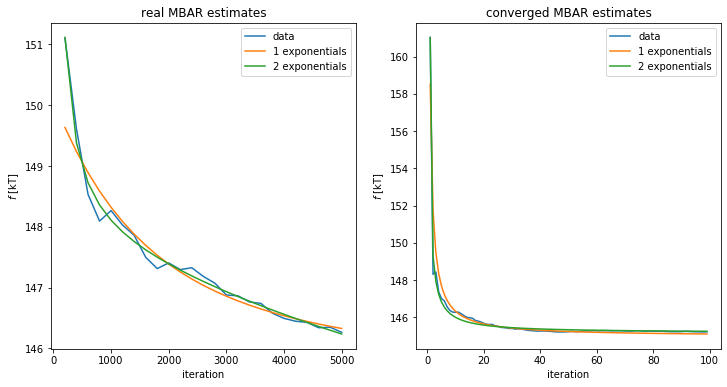

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
titles = ['real MBAR estimates', 'converged MBAR estimates']

for traj_idx, (Df, x) in enumerate(zip(fitted_Deltaf, fitted_iterations)):
    ax = axes[traj_idx]

    # Plot data trajectory.
    ax.plot(x, Df, label='data')
    
    # Plot fitted model.
    for model_idx, n_exp in enumerate(n_exponentials):
        pars = fitted_parameters[traj_idx*len(n_exponentials) + model_idx]
        if pars is not None:
            ax.plot(x, compute_avg_f_t(x, *pars), label=f'{n_exp} exponentials')

    # Configure Axes.
    ax.set_title(titles[traj_idx])
    ax.set_ylabel('$f$ [kT]')
    ax.set_xlabel('iteration')
    ax.legend()
plt.show()

### Fitting of the trailblaze data.

Let's see if we can find the same bias model when fitting the free energy trajectory computed from the trailblaze data.

First let's compute the MBAR free energy trajectory at each trailblaze iteration.

In [21]:
# Load the reduced potentials for all three systems.
system_trailblaze_energies = collections.OrderedDict()
system_names = ['CB8G30', 'OAG30', 'OAG60']
for system_name in system_names:
    system_trailblaze_energies[system_name[:-1]] = np.load(os.path.join(TRAILBLAZE_DIR_PATH, system_name+'.npy'))

In [22]:
# Compute and cache the free energy trajectory.
system_trailblaze_Deltaf_in = collections.OrderedDict()
system_trailblaze_dDeltaf_in = collections.OrderedDict()

Deltaf_file_base_path = os.path.join(BIAS_PREDICTION_CACHE, 'trailblaze-Deltaf')
dDeltaf_file_base_path = os.path.join(BIAS_PREDICTION_CACHE, 'trailblaze-dDeltaf')

iterations = np.array(list(range(1, system_trailblaze_energies['CB8G3'].shape[-1])))

for system_name, trailblaze_energies in system_trailblaze_energies.items():
    Deltaf_file_path = Deltaf_file_base_path + '-' + system_name + '.npy'
    dDeltaf_file_path = dDeltaf_file_base_path + '-' + system_name + '.npy'
    
    # Check first if we have cached some data.
    if os.path.isfile(Deltaf_file_path):
        system_trailblaze_Deltaf_in[system_name] = np.load(Deltaf_file_path)
        system_trailblaze_dDeltaf_in[system_name] = np.load(dDeltaf_file_path)
    else:
        Df, dDf = compute_MBAR_free_energy_trajectory(trailblaze_energies, iterations)
        system_trailblaze_Deltaf_in[system_name] = Df
        system_trailblaze_dDeltaf_in[system_name] = dDf
        
        # Cache result.
        np.save(Deltaf_file_path, Df)
        np.save(dDeltaf_file_path, dDf)

Let's fit the free energy trajectories to the data.

In [23]:
trailblaze_fitted_parameters = collections.OrderedDict((n, {}) for n in system_trailblaze_Deltaf_in.keys())
n_exponentials = [1, 2]
discarded_initial_iterations = 20
fitted_iterations = iterations[discarded_initial_iterations:]

for system_name, Df in system_trailblaze_Deltaf_in.items():
    dDf = system_trailblaze_dDeltaf_in[system_name]
    for n_exp in n_exponentials:
        # curve_fit returns the parameters and the covariance matrix.
        try:
            popt, pcov = fit_f_t(
                n_exponentials=n_exp,
                iterations=fitted_iterations,
                Deltaf=Df[-1][discarded_initial_iterations:],
                dDeltaf=dDf[-1][discarded_initial_iterations:]
            )
        except RuntimeError:
            popt = None
        trailblaze_fitted_parameters[system_name][n_exp] = popt
        
        # Print for logging.
        print(f'System {system_name} fitted with {n_exp} exponentials: {popt}')

System CB8G3 fitted with 1 exponentials: [-147.6839272  -106.60853785    1.01726299]
System CB8G3 fitted with 2 exponentials: None
System OAG3 fitted with 1 exponentials: [-317.17476393 -106.72416395    5.58047001]
System OAG3 fitted with 2 exponentials: None
System OAG6 fitted with 1 exponentials: [-323.01826924  -30.52820409    9.05651884]
System OAG6 fitted with 2 exponentials: None


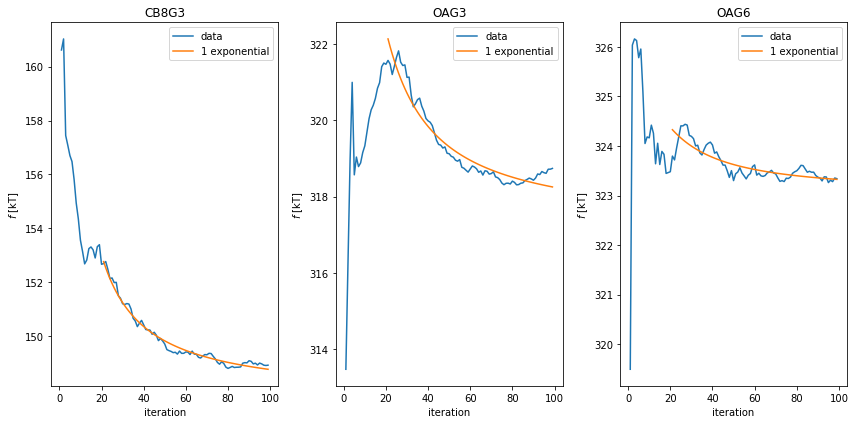

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=len(system_names), figsize=(12, 6))

for system_idx, (system_name, Df) in enumerate(system_trailblaze_Deltaf_in.items()):
    ax = axes[system_idx]

    # Plot data trajectory.
    ax.plot(iterations, Df[-1], label='data')

    # Plot fitted model.
    for model_idx, n_exp in enumerate(n_exponentials):
        pars = trailblaze_fitted_parameters[system_name][n_exp]
        if pars is not None:
            ax.plot(fitted_iterations, compute_avg_f_t(fitted_iterations, *pars), label=f'{n_exp} exponential')

    # Configure Axes.
    ax.set_title(system_name)
    ax.set_ylabel('$f$ [kT]')
    ax.set_xlabel('iteration')
    ax.legend()
plt.tight_layout()
plt.show()

This fitting is not good. The data doesn't fit a double exponential decay model, and the single exponential decay predicts that the decay time of CB8-G3 is two orders of magnitude smaller than the octa acid systems, which is so very wrong.

The model doesn't take into account that $\gamma$ depends on time. Let's see if there is information in the free energy trajectory computed from the weight using the best available MBAR free energy estimates.

In [25]:
initial_iter = 5

system_cumulative_Df_traj_weight = collections.OrderedDict()
for system_name, trailblaze_energies in system_trailblaze_energies.items():
    Df = system_trailblaze_Deltaf_in[system_name]
    iterations = np.array(list(range(initial_iter, Df.shape[-1])))
    
    print(system_name)
    system_cumulative_Df_traj_weight[system_name] = compute_cumulative_Deltaf_weights_traj(
        mbar_energies=trailblaze_energies[:,:,1:],
        Deltaf_in=Df, compute_all_weights=True,
        analyzed_iterations=iterations, verbose=True
    )

CB8G3
Iteration 98 (94/94)
OAG3
Iteration 98 (94/94)
OAG6
Iteration 98 (94/94)


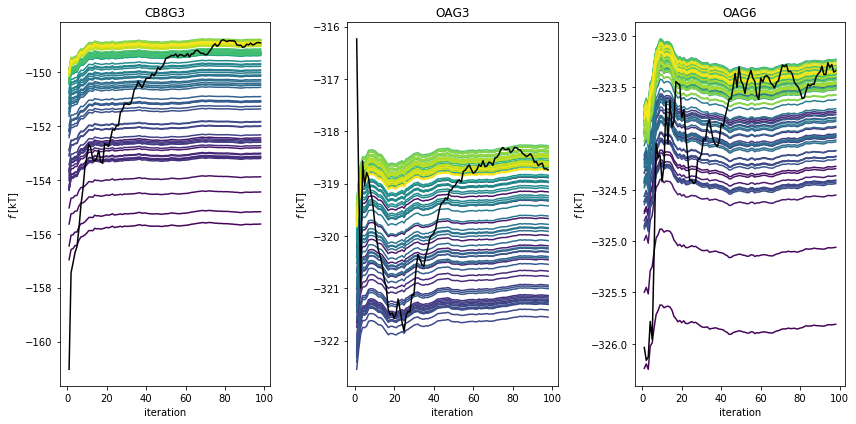

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

for i, (system_name, cumulative_Df_traj_weight) in enumerate(system_cumulative_Df_traj_weight.items()):
    ax = axes[i]
    iterations = np.array(list(range(1, system_trailblaze_Deltaf_in[system_name].shape[-1])))
    viridis = sns.color_palette('viridis', n_colors=len(cumulative_Df_traj_weight))

    for i, Df in enumerate(cumulative_Df_traj_weight):
        # Plot data trajectory.
        ax.plot(iterations, Df, label=str(i), color=viridis[i])

    # Now print the real free energy trajectory.
    ax.plot(iterations, -system_trailblaze_Deltaf_in[system_name][-1][1:], label='real', color='black')
    # Configure Axes.
    ax.set_title(system_name)
    ax.set_ylabel('$f$ [kT]')
    ax.set_xlabel('iteration')
    #ax.legend()

plt.tight_layout()
plt.show()

Try to fit the free energy trajectory computed from the weights and see if we can get a better estimate of the correlation times.

In [39]:
trailblaze_fitted_parameters_weight = collections.OrderedDict(
    [(n, {}) for n in system_cumulative_Df_traj_weight])
n_discarded_iterations = 5

for system_name in system_cumulative_Df_traj_weight.keys():
    Df = system_cumulative_Df_traj_weight[system_name][-1]
    for n_exp in n_exponentials:
        # curve_fit returns the parameters and the covariance matrix.
        try:
            popt, pcov = fit_f_t(
                n_exponentials=n_exp,
                iterations=iterations[n_discarded_iterations:],
                Deltaf=Df[n_discarded_iterations:]
            )
        except RuntimeError:
            popt = None
        trailblaze_fitted_parameters_weight[system_name][n_exp] = popt
        
        # Print for logging.
        print(f'System {system_name} fitted with {n_exp} exponentials: {popt}')

System CB8G3 fitted with 1 exponentials: [1.48892944e+02 2.44630070e+00 3.48211651e-03]
System CB8G3 fitted with 2 exponentials: None
System OAG3 fitted with 1 exponentials: None
System OAG3 fitted with 2 exponentials: None
System OAG6 fitted with 1 exponentials: [323.43365826  -2.3726205    6.0603827 ]
System OAG6 fitted with 2 exponentials: None


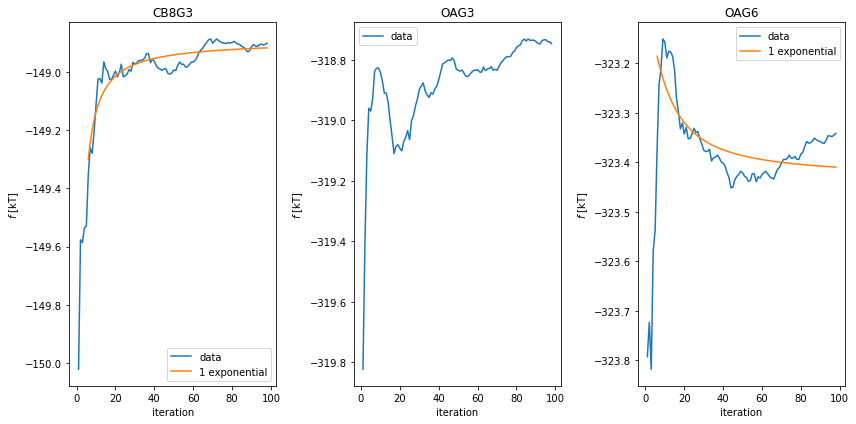

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=len(system_names), figsize=(12, 6))

for system_idx, (system_name, Df) in enumerate(system_cumulative_Df_traj_weight.items()):
    ax = axes[system_idx]

    # Plot data trajectory.
    ax.plot(iterations, Df[-1], label='data')

    # Plot fitted model.
    for model_idx, n_exp in enumerate(n_exponentials):
        pars = trailblaze_fitted_parameters_weight[system_name][n_exp]
        if pars is not None:
            ax.plot(iterations[n_discarded_iterations:],
                    compute_avg_f_t(iterations[n_discarded_iterations:], *pars),
                    label=f'{n_exp} exponential')

    # Configure Axes.
    ax.set_title(system_name)
    ax.set_ylabel('$f$ [kT]')
    ax.set_xlabel('iteration')
    ax.legend()
plt.tight_layout()
plt.show()

-147.2


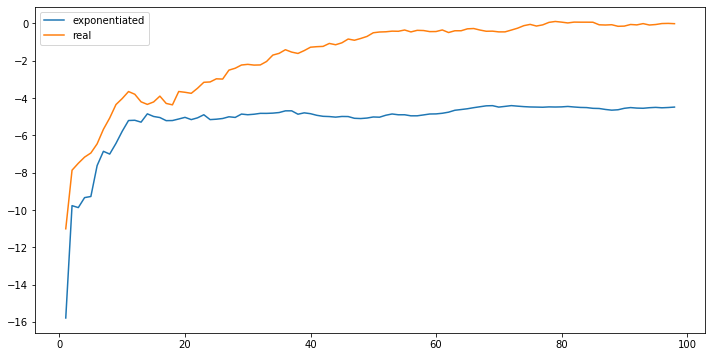

In [69]:
asymptotic_log_w = -144.7
asymptotic_log_w = -147.2
# asymptotic_log_w = -system_trailblaze_Deltaf_in[system_name][-1][-1]
print(asymptotic_log_w)

exponentiated = cumulative_Df_traj_weight[-1] - asymptotic_log_w # - cumulative_Df_traj_weight[-1][-1]
exponentiated = -(np.exp(-exponentiated) - 1)

real = -system_trailblaze_Deltaf_in[system_name][-1][1:] - cumulative_Df_traj_weight[-1]# - asymptotic_log_w
# real -= real[-1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
# ax.plot(iterations, cumulative_Df_traj_weight[-1], label='log')
ax.plot(iterations, exponentiated, label='exponentiated')
ax.plot(iterations, real, label='real')
ax.legend()
plt.show()

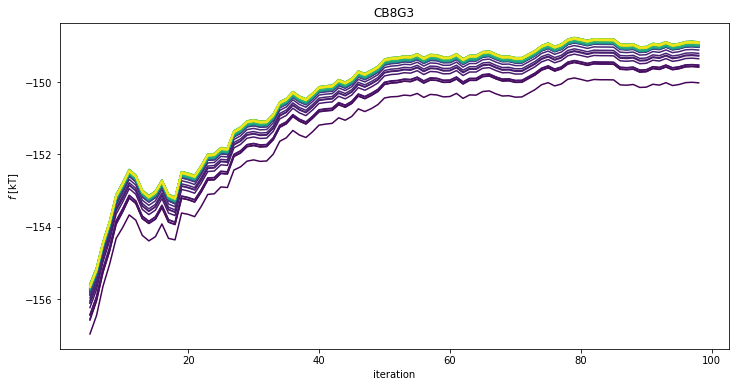

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

for i, iteration in enumerate(iterations[initial_iter:]):
    Df = [f[i] for f in cumulative_Df_traj_weight]
    # Plot data trajectory.
    ax.plot(iterations[initial_iter-1:], Df, label=str(iteration), color=viridis[i])

# Now print the real free energy trajectory.
#ax.plot(iterations[1:], -system_trailblaze_Deltaf_in[system_name][-1], label='real', color='black')
# Configure Axes.
ax.set_title(system_name)
ax.set_ylabel('$f$ [kT]')
ax.set_xlabel('iteration')
# ax.legend()
plt.show()

## How closely can we estimate the free energies with only 100 samples?

First let's compare the MBAR free energy computed from these 100 predictions with the converged free energies computed for SAMPLing.

In [3]:
# Load the SAMPLing free energies. This file is generated in the mbar_weight notebook.
converged_Deltaf_file_path = os.path.join('..', 'mbar_weights', 'cache', 'Deltaf-3.npz')
converged_Deltaf_ij = np.load(converged_Deltaf_file_path)['arr_0']
converged_dDeltaf_ij = np.load(converged_Deltaf_file_path)['arr_1']

# trailblaze_energies[i][j][n] is the reduced potential sampled
# from state i at iteration n and evaluated at state j.
trailblaze_energies = np.load(os.path.join(TRAILBLAZE_DIR_PATH, 'CB8G30.npy'))

n_samples_per_state = trailblaze_energies.shape[-1]
n_states = trailblaze_energies.shape[0]
assert n_states == converged_Deltaf_ij.shape[0]

# Compute the MBAR prediction with only the 100 samples.
import pymbar
N_k = np.array([n_samples_per_state for _ in range(n_states)])
mbar = pymbar.MBAR(trailblaze_energies, N_k=N_k)
trailblaze_Deltaf_ij, trailblaze_dDeltaf_ij, _ = mbar.getFreeEnergyDifferences()

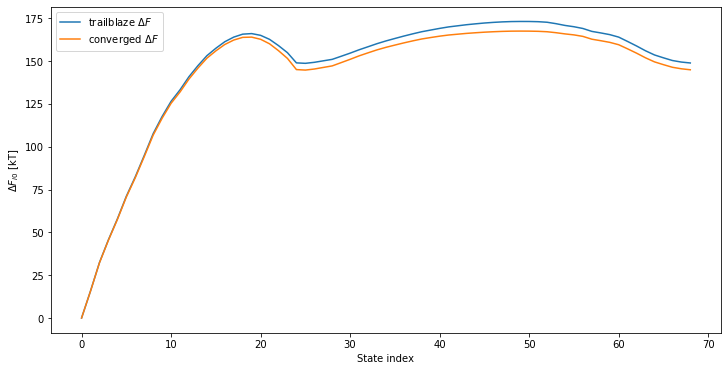

In [4]:
# Plot both predictions.
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(trailblaze_Deltaf_ij[0], label='trailblaze $\Delta F$')
ax.plot(converged_Deltaf_ij[0], label='converged $\Delta F$')
ax.legend()
ax.set_xlabel('State index')
ax.set_ylabel('$\Delta F_{i0}$ [kT]')
plt.show()

The binding free energy is too positive as expected, but it's surprisingly good considering that it was computed from only 100 correlated samples. Note how the bias is pushed entirely on the decoupled state as a result of forcing $f_0 = 0$.

## Model of the bias decay (old)

Let's try to fit the time series of the MBAR weights to a single exponential decay model. First we try with the converged data to check if the model holds. We'll check what happens when we switch to the short trailblaze data afterwards.

In [5]:
# Load the asymptotic MBAR weights. This file is generated in the mbar_weight notebook.
converged_log_weights_file_path = os.path.join('..', 'mbar_weights', 'cache', 'log_weights-0.npz')
converged_log_weights = np.load(converged_log_weights_file_path)['arr_0']

# Convert to scaled MBAR weights.
converged_scaled_weights = compute_scaled_mbar_weight_trajectories(converged_log_weights)

Plot the log weights and scaled log weights to see if there's any resemblance to exponential decay.

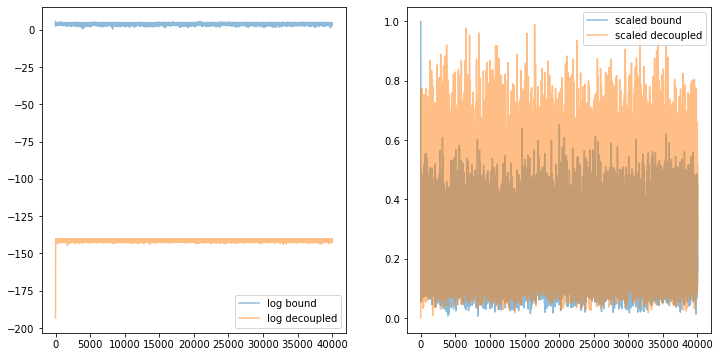

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for ax_idx, (w, label) in enumerate([
    [converged_log_weights, 'log'],
    [converged_scaled_weights, 'scaled']
]):
    ax = axes[ax_idx]
    ax.plot(w[0], label=label+' bound', alpha=0.5)
    ax.plot(w[1], label=label+' decoupled', alpha=0.5)
    ax.legend()
plt.show()

Now let's plot the moving average of their difference for increasing values of the moving average window.

Running 39/39

/Users/andrea/miniconda/envs/bleedingedge/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


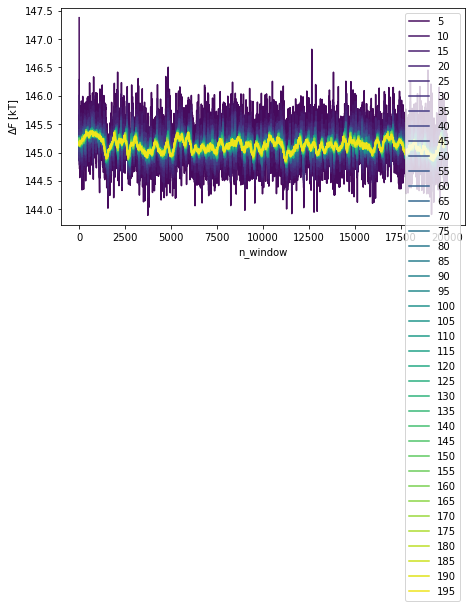

In [41]:
min_window_size = 5
max_window_size = 200
step_window_size = 5

window_sizes = list(range(min_window_size, max_window_size, step_window_size))
n_window_sizes = len(window_sizes)
viridis_colors = sns.color_palette('viridis', n_window_sizes)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for window_idx, window_size in enumerate(window_sizes):
    print(f'\rRunning {window_idx+1}/{n_window_sizes}', end='')

    color = viridis_colors[window_idx]
    #n_windows = converged_log_weights.shape[-1] - window_size + 1
    n_windows = 10000 - window_size + 1

    # Compute the moving average trajectory.
    f_traj = np.empty(n_windows)
    for i in range(n_windows):
        f_traj[i] = logsumexp(converged_log_weights[0][i:i+window_size] - np.log(window_size))
        f_traj[i] -= logsumexp(converged_log_weights[1][i:i+window_size] - np.log(window_size))

    # Plot this particular trajectory.
    ax.plot(f_traj, label=str(window_size), color=color)

ax.set_ylabel('$\Delta F$ [kT]')
ax.set_xlabel('n_window')
ax.legend()
plt.show()